# Install Dependencies

In [1]:
%pip install opencv-python albumentations numpy pillow tqdm matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ----------------------

# Imports

In [20]:
import cv2
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image, ImageEnhance
from albumentations import (HorizontalFlip, ShiftScaleRotate, GaussNoise, 
                            RandomBrightnessContrast, RandomGamma, 
                            ElasticTransform, GaussianBlur)
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# Preprocessing and augmentation

In [28]:
def enhance_image(image):
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    enhancer = ImageEnhance.Sharpness(pil_image)
    enhanced_image = enhancer.enhance(2.0)
    return cv2.cvtColor(np.array(enhanced_image), cv2.COLOR_RGB2BGR)

def resize_image(image):
    return cv2.resize(image, (224, 224))

def preprocessing(image):
    image = resize_image(image)
    image = enhance_image(image)
    return image

# Add salt-and-pepper noise
def add_salt_and_pepper_noise(image, amount=0.01, salt_vs_pepper=0.5):
    row, col, ch = image.shape
    num_salt = np.ceil(amount * image.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_vs_pepper))

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    image[coords[0], coords[1], :] = 1

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    image[coords[0], coords[1], :] = 0
    return image

# Get random augmentations for an image
def get_random_augmentations(existing_combinations, img_name):
    while True:
        num_transformations = random.randint(1, len(augmentation_methods))
        selected_names = random.sample(list(augmentation_methods.keys()), num_transformations)
        combination_key = tuple(sorted(selected_names))

        if combination_key not in existing_combinations.get(img_name, set()):
            return selected_names

# Apply augmentations
def apply_augmentations(img, augmentations, augmented_images_count):
    transformation_labels = []
    applied_types = set()

    for aug in augmentations:
        if aug in augmentation_methods:
            transform, transform_type = augmentation_methods[aug]

            if transform_type not in applied_types:
                if aug == "salt_and_pepper":
                    img = add_salt_and_pepper_noise(img)
                else:
                    img = transform(image=img)["image"]

                transformation_labels.append(aug)
                applied_types.add(transform_type)

    return img, transformation_labels, augmented_images_count + 1

# Apply augmentations and save the augmented image
def augment_image(img, img_name, augmentations, output_dir, existing_combinations, augmented_images_count):
    transformed, transformation_labels, augmented_images_count = apply_augmentations(img, augmentations, augmented_images_count)

    base_name = os.path.splitext(img_name)[0]
    unique_name = f"{base_name}_{augmented_images_count}.jpg"
    output_path = os.path.join(output_dir, unique_name)
    cv2.imwrite(output_path, transformed)

    combination_key = tuple(sorted(transformation_labels))
    if img_name not in existing_combinations:
        existing_combinations[img_name] = set()
    existing_combinations[img_name].add(combination_key)

    transformation_metadata = {aug: augmentation_methods[aug][1] for aug in transformation_labels}
    
    return augmented_images_count, transformation_metadata, unique_name

# Augment dataset until target size is reached
def augment_dataset(augmented_class_path, target_image_count):
    augmented_images_count = len(os.listdir(augmented_class_path))
    print(f'Initial augmented images count: {augmented_images_count}')

    existing_combinations = {}
    augmentation_metadata = {}

    while augmented_images_count < target_image_count:
        for img_name in os.listdir(augmented_class_path):
            img = cv2.imread(os.path.join(augmented_class_path, img_name))

            augmentations = get_random_augmentations(existing_combinations, img_name)

            augmented_images_count, transformation_metadata, saved_image_name = augment_image(
                img, img_name, augmentations, augmented_class_path, existing_combinations, augmented_images_count
            )

            augmentation_metadata[saved_image_name] = transformation_metadata
            print(f'Augmented image saved: {saved_image_name}, Count: {augmented_images_count}')
            
            if augmented_images_count >= target_image_count:
                break

    save_metadata(augmentation_metadata, './Datasets/augmentation_metadata.json')
    print(f'Final augmented images count: {augmented_images_count}')

def create_datasets():
    raw_data_dir = './Datasets/Dataset_O'
    small_data_dir = './Datasets/Dataset_S'
    large_data_dir = './Datasets/Dataset_L'
    target_large_dataset_size = 40000

    os.makedirs(small_data_dir, exist_ok=True)
    os.makedirs(large_data_dir, exist_ok=True)

    classes = os.listdir(raw_data_dir)
    excluded_images = set()

    for class_name in classes:
        class_path = os.path.join(raw_data_dir, class_name)
        small_class_path = os.path.join(small_data_dir, class_name)
        
        os.makedirs(small_class_path, exist_ok=True)
        excluded_images.update(save_small_dataset(class_path, small_class_path))

    copy_raw_to_large_dataset(raw_data_dir, large_data_dir, excluded_images)
    augment_dataset(large_data_dir, target_large_dataset_size)

def save_small_dataset(class_path, small_class_path, num_small_images=500):
    images = [img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = images[:num_small_images]
    excluded_images = set(selected_images)

    for img_name in tqdm(selected_images, desc=f'Saving small dataset for {class_path}'):
        img = cv2.imread(os.path.join(class_path, img_name))
        img_processed = preprocessing(img)
        cv2.imwrite(os.path.join(small_class_path, img_name), img_processed)

    return excluded_images

def copy_raw_to_large_dataset(raw_data_dir, large_data_dir, excluded_images):
    for dirpath, _, filenames in tqdm(os.walk(raw_data_dir), desc='Copying images to large dataset'):
        for img_name in filenames:
            if img_name.endswith(('.png', '.jpg', '.jpeg')) and img_name not in excluded_images:
                src_path = os.path.join(dirpath, img_name)
                dst_path = os.path.join(large_data_dir, img_name)

                base_name, ext = os.path.splitext(img_name)
                counter = 1
                while os.path.exists(dst_path):
                    dst_path = os.path.join(large_data_dir, f"{base_name}_{counter}{ext}")
                    counter += 1

                cv2.imwrite(dst_path, cv2.imread(src_path))

def save_metadata(metadata, output_file):
    with open(output_file, 'w') as f:
        json.dump(metadata, f, indent=4)

# Augmentation methods with their types
augmentation_methods = {
    "horizontal_flip": (HorizontalFlip(p=0.5), "geometric"),
    "shift_scale_rotate": (ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0, p=0.5), "geometric"),
    "gauss_noise": (GaussNoise(var_limit=(0, 10), p=0.4), "noise"),
    "brightness_contrast": (RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.6), "color"),
    "random_gamma": (RandomGamma(gamma_limit=(85, 115), p=0.4), "color"),
    "elastic_transform": (ElasticTransform(alpha=1, sigma=50, p=0.5), "other"),
    "gaussian_blur": (GaussianBlur(blur_limit=(1, 3), p=0.5), "other"),
    "salt_and_pepper": ("salt_and_pepper", "noise")
}

create_datasets()


Saving small dataset for ./Datasets/Dataset_O\COVID2_CT: 100%|██████████| 500/500 [00:03<00:00, 164.63it/s]
Saving small dataset for ./Datasets/Dataset_O\Normal_CT: 100%|██████████| 500/500 [00:03<00:00, 159.80it/s]
Saving small dataset for ./Datasets/Dataset_O\pneumonia_CT: 100%|██████████| 500/500 [00:02<00:00, 173.31it/s]
Copying images to large dataset: 4it [00:46, 11.60s/it]


Initial augmented images count: 5980
Augmented image saved: 204 (10)_5981.jpg, Count: 5981
Augmented image saved: 204 (11)_5982.jpg, Count: 5982
Augmented image saved: 204 (12)_5983.jpg, Count: 5983
Augmented image saved: 204 (13)_5984.jpg, Count: 5984
Augmented image saved: 204 (14)_5985.jpg, Count: 5985
Augmented image saved: 204 (15)_5986.jpg, Count: 5986
Augmented image saved: 204 (16)_5987.jpg, Count: 5987
Augmented image saved: 204 (17)_5988.jpg, Count: 5988
Augmented image saved: 204 (18)_5989.jpg, Count: 5989
Augmented image saved: 204 (19)_5990.jpg, Count: 5990
Augmented image saved: 204 (2)_5991.jpg, Count: 5991
Augmented image saved: 204 (20)_5992.jpg, Count: 5992
Augmented image saved: 204 (21)_5993.jpg, Count: 5993
Augmented image saved: 204 (22)_5994.jpg, Count: 5994
Augmented image saved: 204 (23)_5995.jpg, Count: 5995
Augmented image saved: 204 (24)_5996.jpg, Count: 5996
Augmented image saved: 204 (25)_5997.jpg, Count: 5997
Augmented image saved: 204 (26)_5998.jpg, Coun

## Large Unlabelled Data Augmentation Transformations Visualization

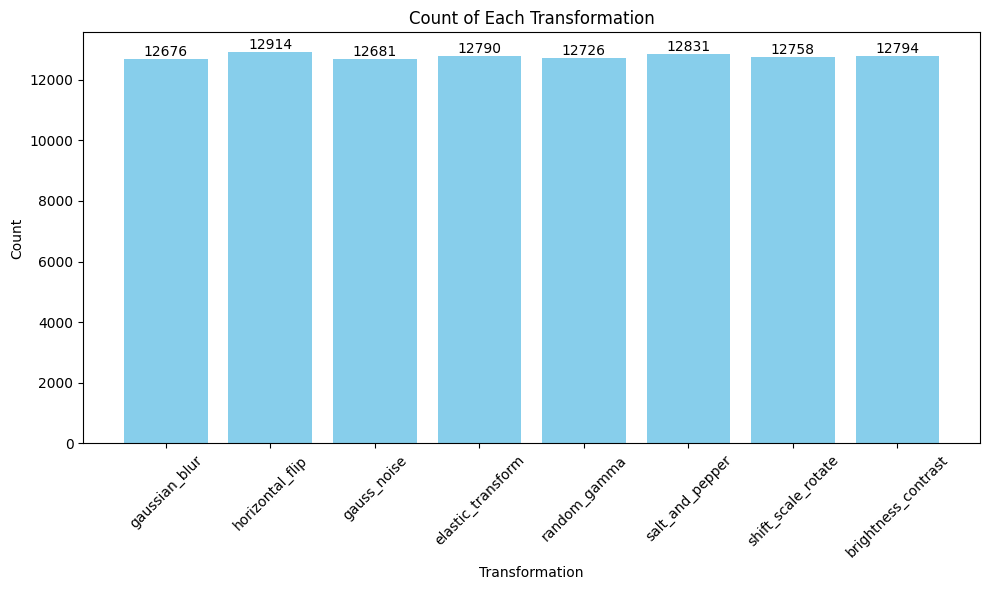

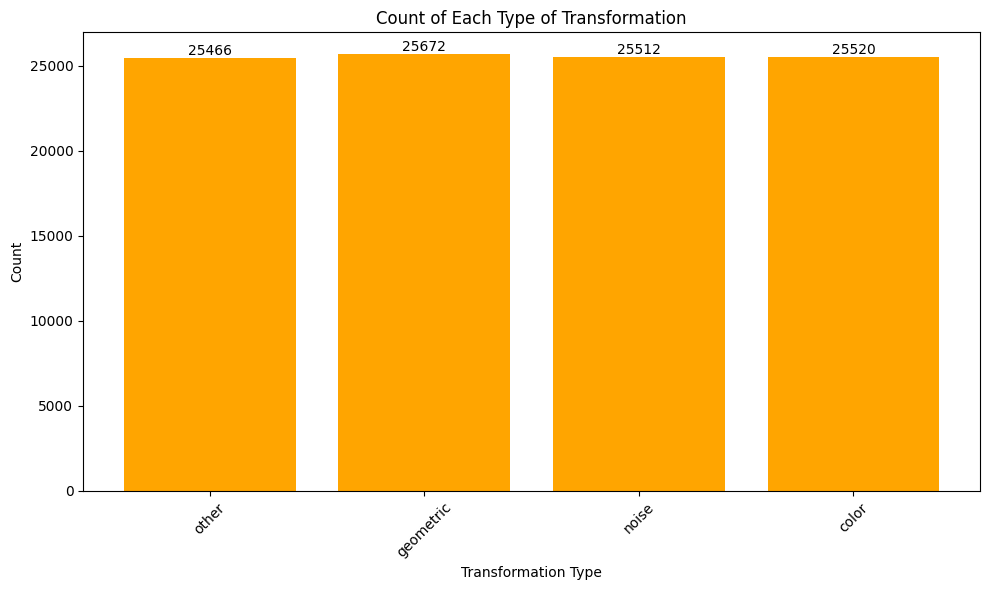

In [34]:
def load_metadata(metadata_file):
    with open(metadata_file, "r") as f:
        return json.load(f)


def plot_transformation_counts(metadata_file):
    metadata = load_metadata(metadata_file)

    transformation_counts = {}

    for image_data in metadata.values():
        for transformation in image_data:
            if transformation in transformation_counts:
                transformation_counts[transformation] += 1
            else:
                transformation_counts[transformation] = 1

    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        transformation_counts.keys(), transformation_counts.values(), color="skyblue"
    )
    plt.xlabel("Transformation")
    plt.ylabel("Count")
    plt.title("Count of Each Transformation")
    plt.xticks(rotation=45)
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.05,
            int(yval),
            ha="center",
            va="bottom",
        )

    plt.show()


metadata_file = "./Datasets/augmentation_metadata.json"
plot_transformation_counts(metadata_file)


def plot_transformation_type_counts(metadata_file):
    metadata = load_metadata(metadata_file)

    type_counts = {}

    for image_data in metadata.values():
        for transformation, transformation_type in image_data.items():
            if transformation_type in type_counts:
                type_counts[transformation_type] += 1
            else:
                type_counts[transformation_type] = 1

    plt.figure(figsize=(10, 6))
    bars = plt.bar(type_counts.keys(), type_counts.values(), color="orange")
    plt.xlabel("Transformation Type")
    plt.ylabel("Count")
    plt.title("Count of Each Type of Transformation")
    plt.xticks(rotation=45)
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.05,
            int(yval),
            ha="center",
            va="bottom",
        )

    plt.show()


plot_transformation_type_counts(metadata_file)